In [2]:
from glob import glob
import cv2
from matplotlib import pyplot as plt
# %matplotlib ipympl

ball_frame_gt_files = glob('ball_frames/*GT.png')
ball_frame_files = [f for f in glob('ball_frames/*.png') if f not in ball_frame_gt_files]

ball_frame_gt_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0].split(".")[0].split("-")[1]))
ball_frame_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0].split(".")[0].split("-")[1]))

print(ball_frame_files)
print(ball_frame_gt_files)
print(len(ball_frame_files), len(ball_frame_gt_files))


['ball_frames/frame-54.png', 'ball_frames/frame-55.png', 'ball_frames/frame-56.png', 'ball_frames/frame-57.png', 'ball_frames/frame-58.png', 'ball_frames/frame-59.png', 'ball_frames/frame-60.png', 'ball_frames/frame-61.png', 'ball_frames/frame-62.png', 'ball_frames/frame-63.png', 'ball_frames/frame-64.png', 'ball_frames/frame-65.png', 'ball_frames/frame-66.png', 'ball_frames/frame-67.png', 'ball_frames/frame-68.png', 'ball_frames/frame-69.png', 'ball_frames/frame-70.png', 'ball_frames/frame-71.png', 'ball_frames/frame-72.png', 'ball_frames/frame-73.png', 'ball_frames/frame-74.png', 'ball_frames/frame-75.png', 'ball_frames/frame-76.png', 'ball_frames/frame-77.png', 'ball_frames/frame-78.png', 'ball_frames/frame-79.png', 'ball_frames/frame-80.png', 'ball_frames/frame-81.png', 'ball_frames/frame-82.png', 'ball_frames/frame-83.png', 'ball_frames/frame-84.png', 'ball_frames/frame-85.png', 'ball_frames/frame-86.png', 'ball_frames/frame-87.png', 'ball_frames/frame-88.png', 'ball_frames/frame-

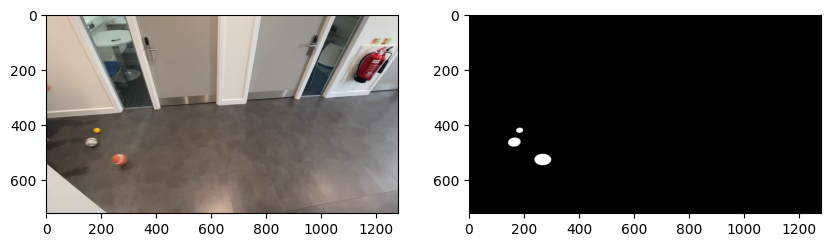

In [3]:
sample_idx = 4
img = cv2.imread(ball_frame_files[sample_idx])
img_gt = cv2.imread(ball_frame_gt_files[sample_idx])

plt.rcParams['figure.figsize'] = [10, 5]
# plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))

In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

def run_kmean(smoothened_img, n_regions = 25):

    graph = image.img_to_graph(smoothened_img)

    # Take a decreasing function of the gradient: an exponential
    # The smaller beta is, the more independent the segmentation is of the
    # actual image. For beta=1, the segmentation is close to a voronoi
    beta = 10
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

    
    n_regions_plus = 3
    assign_labels = "kmeans"
    print('Processing', assign_labels)
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(smoothened_img.shape)

    return labels, n_regions

def plot_contours(labels, n_regions, rescaled_img):
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_img, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = f"Spectral clustering: {assign_labels}"
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
    plt.show()


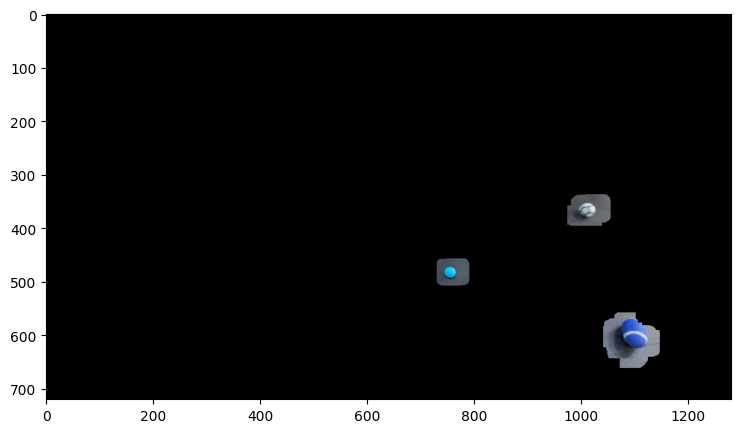

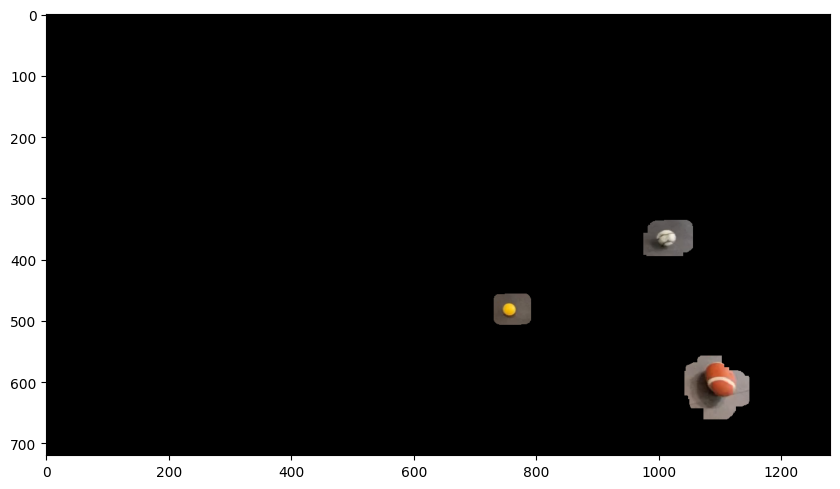

In [5]:
def estimate_motion_area(img1, img2):
    diff_img = cv2.absdiff(img1, img2)
    diff_gray_img = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(diff_gray_img, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=25)
    mask = (1*(mask > 30)).astype(np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 15)

    return mask

img1 = cv2.imread(ball_frame_files[50])
img2 = cv2.imread(ball_frame_files[51])

plt.figure()
# plt.imshow(diff_gray_img, cmap='gray')
mask = estimate_motion_area(img1, img2)

result1 = cv2.bitwise_and(img1, img1, mask= mask)
result2 = cv2.bitwise_and(img1, img1, mask= mask)

plt.imshow(result1)
plt.figure()
plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.savefig('../report/figures/motion_mask.png')


# smoothened_img = gaussian_filter(diff_gray_img, sigma=2)
# rescaled_img = rescale(smoothened_img, 0.1, mode="reflect", anti_aliasing=False)

# labels, n_regions = run_kmean(rescaled_img)
# plot_contours(labels, n_regions, rescaled_img)

# ret,thresh1 = cv2.threshold(diff_img,100,255,cv2.THRESH_BINARY)

# plt.imshow(thresh1, cmap='gray')

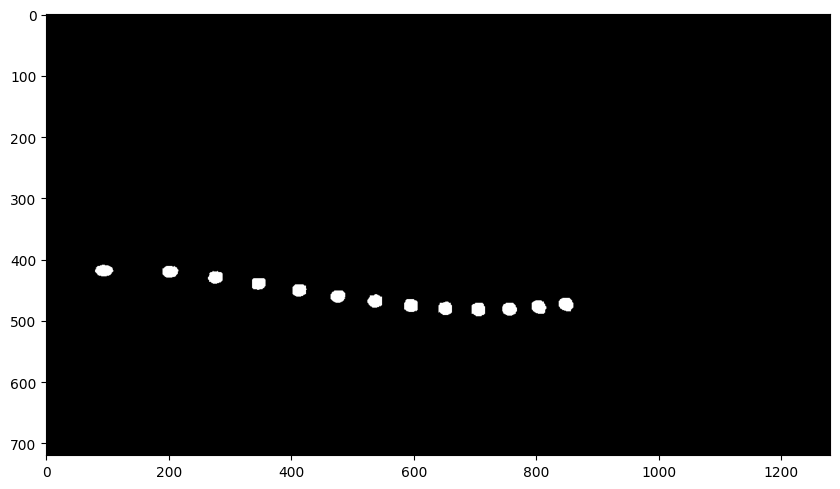

In [6]:
def yellow_color_thresholding(img, connected_component=True):
    # color threshold
    yellow_ball_color = [233, 178, 32]
    yellow_ball_hsv = [22, 220, 233]
    yellow_ball_hsv_low = np.array([15, 100, 100])
    yellow_ball_hsv_high = np.array([30, 256, 256])

    yellow_img = np.zeros([1, 1, 3], dtype=np.uint8)
    yellow_img[0, 0] = yellow_ball_color
    # print(cv2.cvtColor(yellow_img, cv2.COLOR_RGB2HSV))

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    frame_threshold = cv2.inRange(hsv_img, yellow_ball_hsv_low, yellow_ball_hsv_high)

    # de-noise
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    opened = cv2.morphologyEx(frame_threshold, cv2.MORPH_OPEN, kernel)

    # Close the wholes
    closed = cv2.morphologyEx(frame_threshold, cv2.MORPH_CLOSE, kernel)

    if connected_component:
        # Find the biggest connected component
        connectivity = 4
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
            closed, connectivity, cv2.CV_32S
        )

        sizes = stats[:, -1]

        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]
        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255

        return img2.astype(np.uint8)
    else:
        return closed

img = None
for i in range(0, len(ball_frame_files), 5):
    img1 = cv2.imread(ball_frame_files[i])
    img2 = yellow_color_thresholding(img1)

    if img is None:
        img = np.zeros_like(img2)
    img = cv2.bitwise_or(img, img2)
plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.savefig('../report/figures/yellow_ball_mask_seq.png')

# img1 = cv2.imread(ball_frame_files[50])
# img2 = yellow_color_thresholding(img1, connected_component=False)
# plt.imshow(img2, cmap="gray")
# plt.tight_layout()
# plt.savefig('../report/figures/noisy_yellow_ball_mask.png')



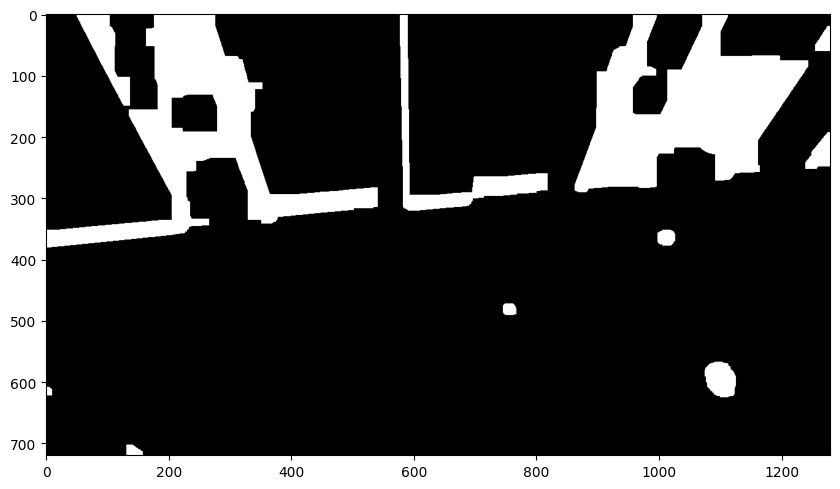

In [7]:
def ball_detection_morph(img, edge_only=False):
    edges = cv2.Canny(img,100,200)
    kernel = np.ones((3,3),np.uint8)

    if edge_only:
        return edges
    # img = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=20)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=5)
    # contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # result = cv2.drawContours(img, contours, -1, (0,255,0), -1)

    return img

img1 = cv2.imread(ball_frame_files[50])
img1 = ball_detection_morph(img1, edge_only=True)
plt.imshow(img1, cmap='gray')
plt.tight_layout()
plt.savefig('../report/figures/edge_detection.png')

img1 = ball_detection_morph(img1)
plt.imshow(img1, cmap='gray')
plt.tight_layout()
plt.savefig('../report/figures/morph_mask.png')


0.849945741281514


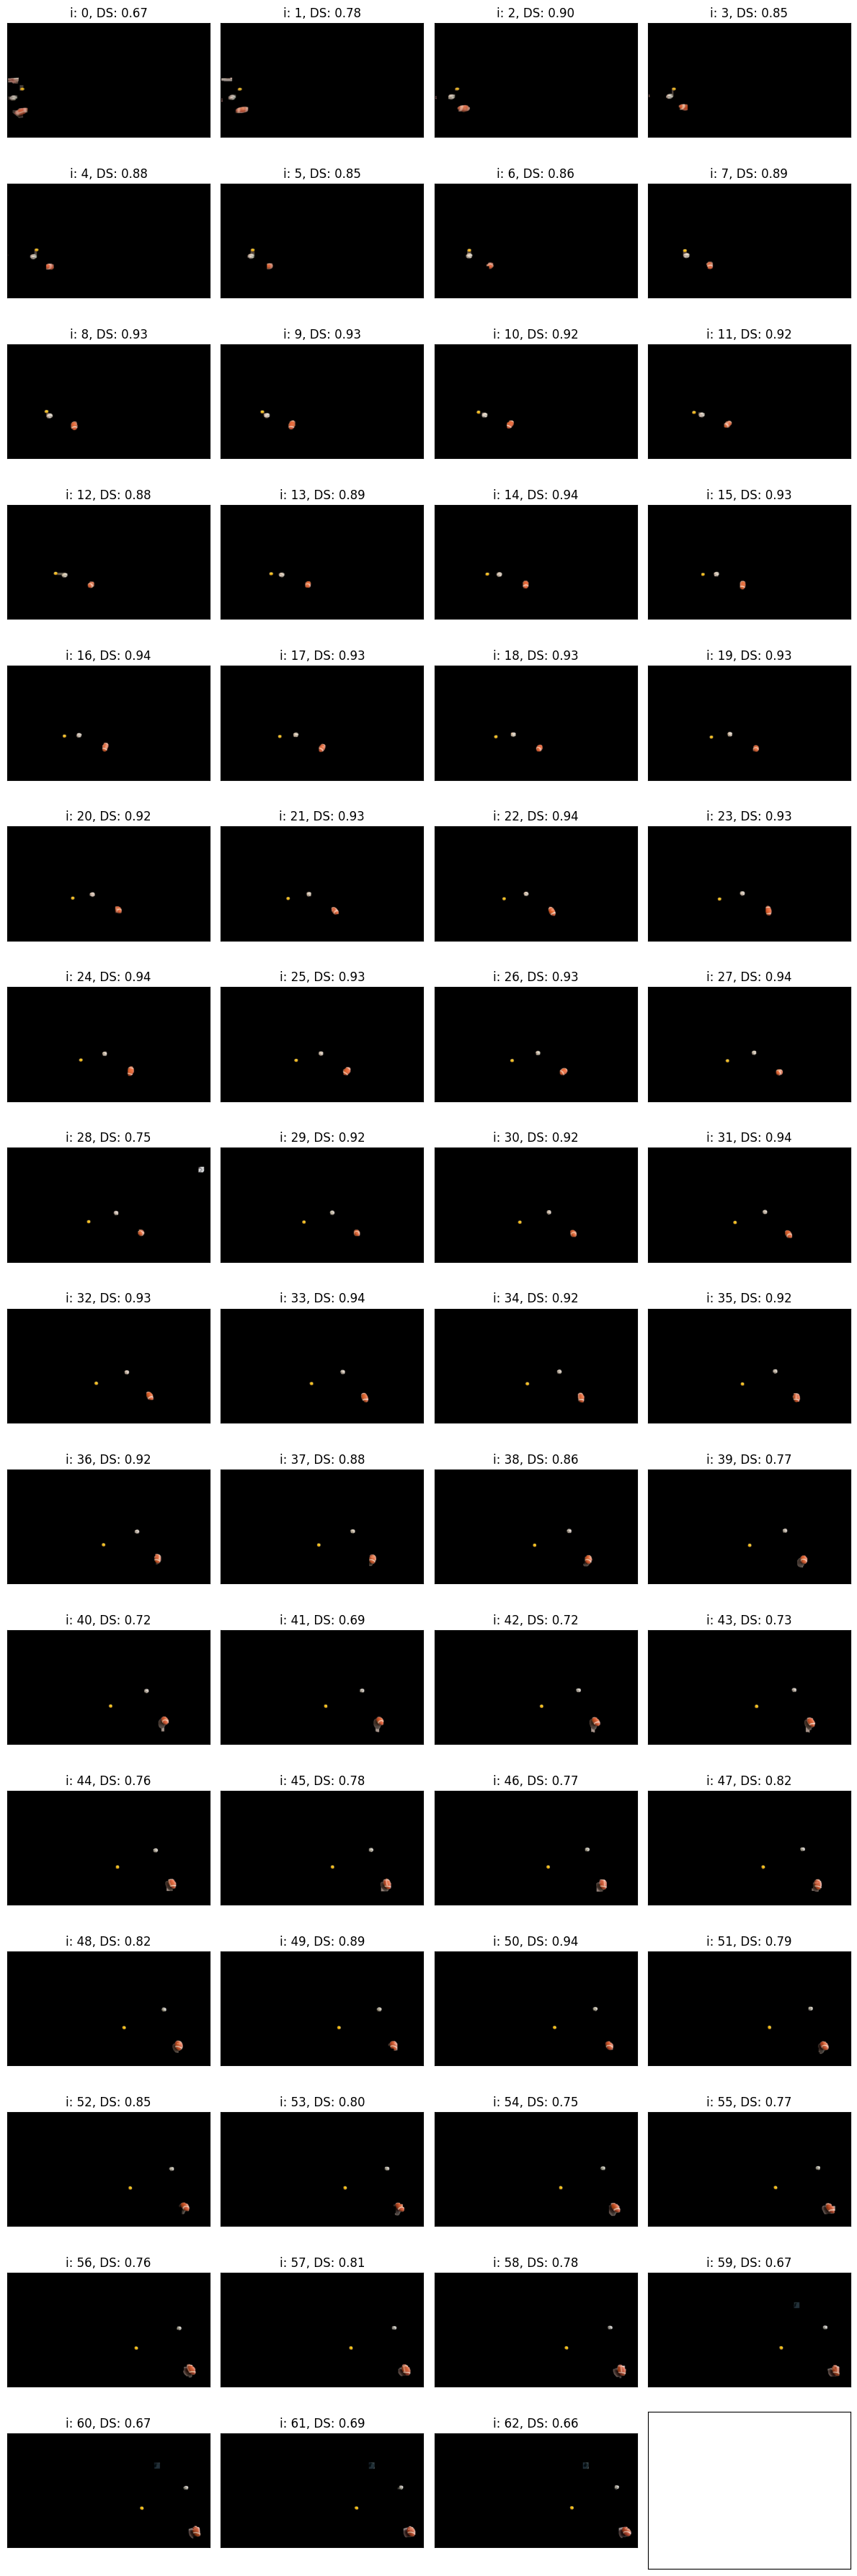

In [8]:
def get_mask(idx):
    img = cv2.imread(ball_frame_files[idx])

    mask_1 = ball_detection_morph(img)
    mask_2 = yellow_color_thresholding(img)

    
    nxt_idx = idx + 1
    if nxt_idx == len(ball_frame_files):
        nxt_idx = idx - 1
    next_img = cv2.imread(ball_frame_files[nxt_idx])
    mask = cv2.bitwise_or(mask_1, mask_2)
    motion_mask = estimate_motion_area(img, next_img)
    mask = cv2.bitwise_and(mask, motion_mask)

    return mask

def get_gt_mask(idx):
    gt_mask = cv2.imread(ball_frame_gt_files[idx])
    gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
    gt_mask = gt_mask.astype(np.uint8)
    gt_mask = (1 * (gt_mask > 50)).astype(np.uint8)
    return gt_mask

_, axs = plt.subplots(16, 4, figsize=(12, 36))
axs = axs.flatten()

DSs = []
for idx, fn, fn_gt, ax in list(zip( range(len(ball_frame_files)),
    ball_frame_files, ball_frame_gt_files, axs
)):
    img = cv2.imread(fn)
    mask = get_mask(idx)
    gt_mask = get_gt_mask(idx)

    DS = 2 * np.sum(cv2.bitwise_and(gt_mask, mask)) / (np.sum(mask) + np.sum(gt_mask))
    masked_img = cv2.bitwise_and(img, img, mask = mask)

    # ax.imshow(gt_mask, cmap='gray')
    ax.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    ax.title.set_text(f"i: {idx}, DS: {DS:.2f}")
    DSs.append(DS)

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
print(np.mean(DSs))
plt.savefig("../report/figures/segmentation_results.png")

0.849945741281514 0.08905446903424515


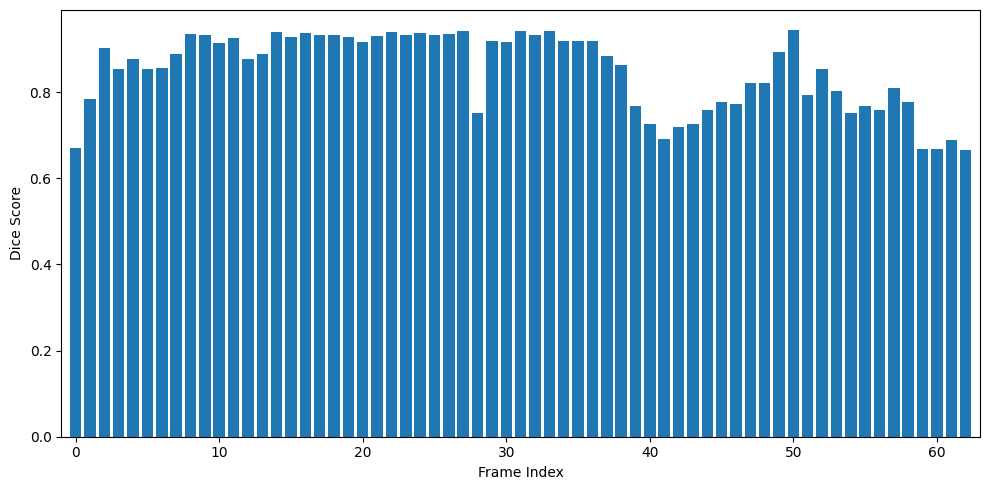

In [9]:
print(np.mean(DSs), np.std(DSs))

plt.bar(height=DSs, x=range(len(DSs)))
plt.xlabel('Frame Index')
plt.ylabel('Dice Score')
plt.tight_layout()
plt.xlim(-1, len(DSs))
plt.savefig('../report/figures/dice_score.png')

0.849945741281514 0.08905446903424515


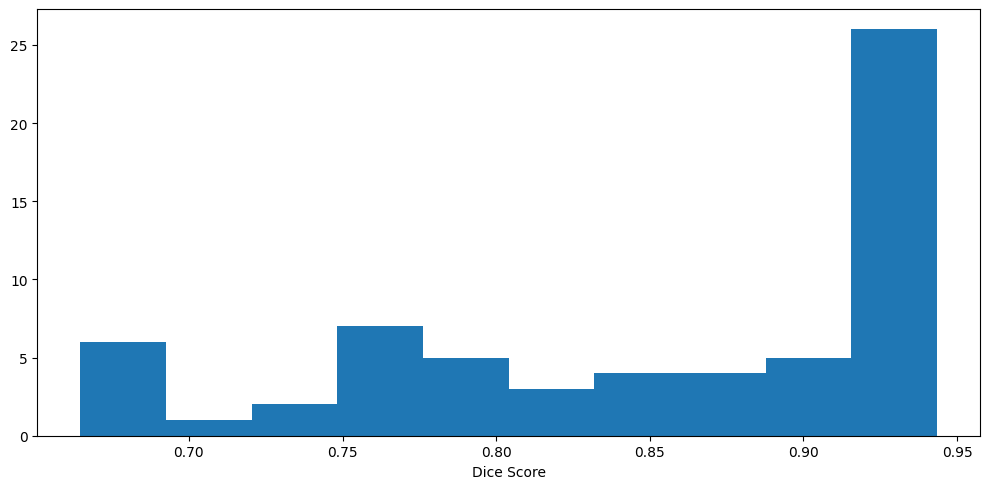

In [10]:
print(np.mean(DSs), np.std(DSs))

plt.hist(DSs)
plt.xlabel('Dice Score')
plt.tight_layout()
plt.savefig('../report/figures/dice_score_hist.png')

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


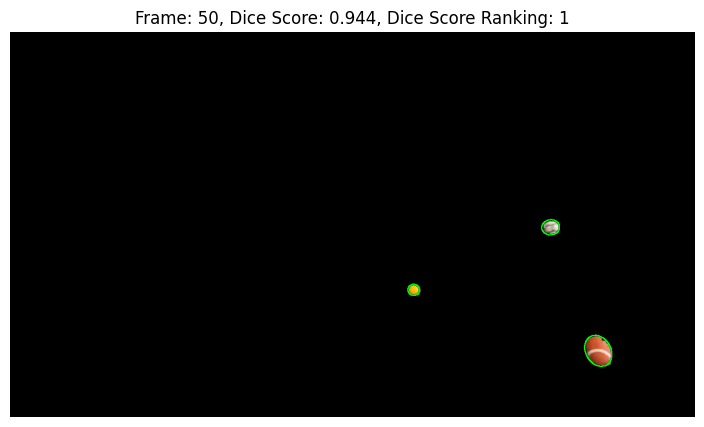

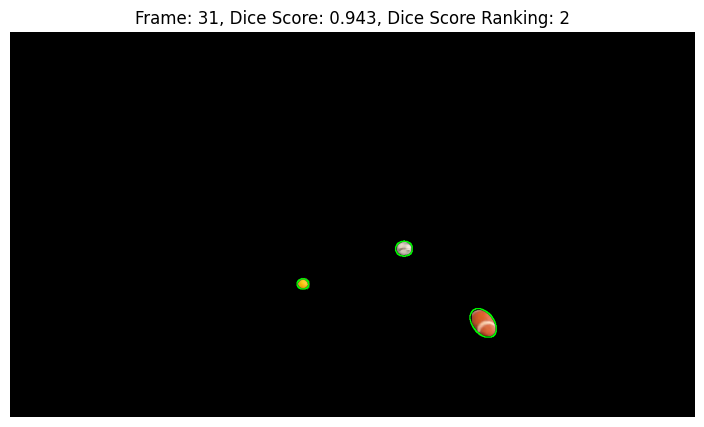

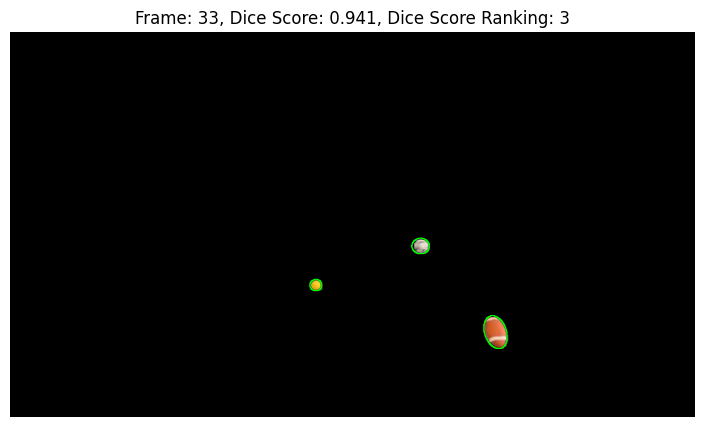

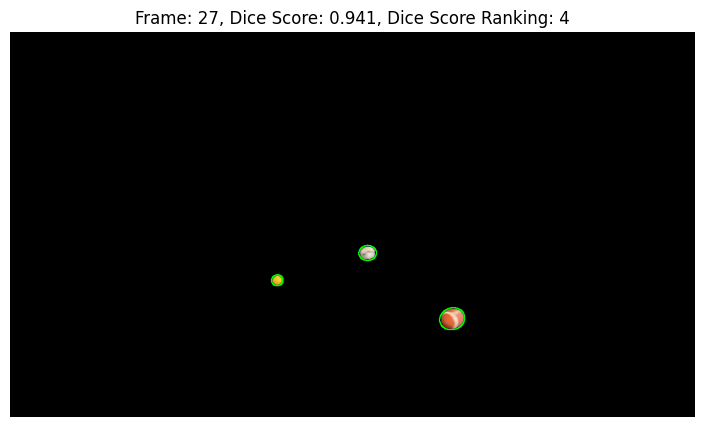

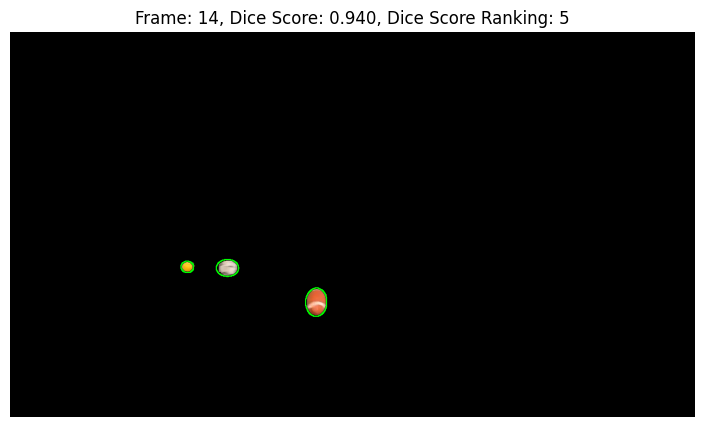

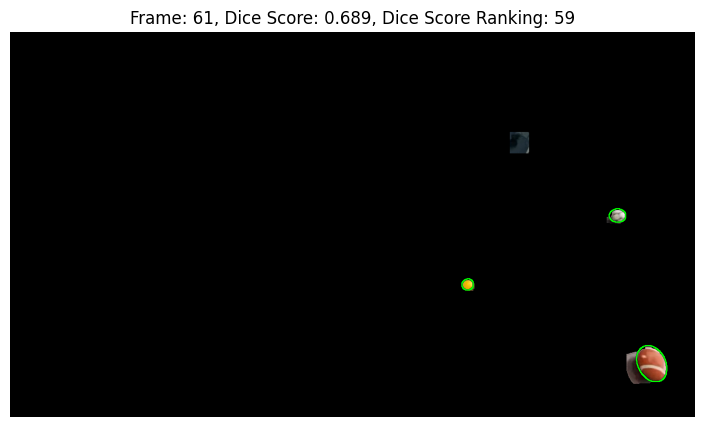

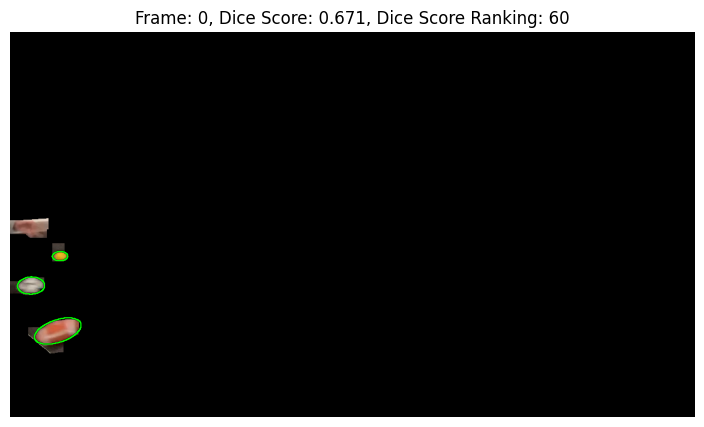

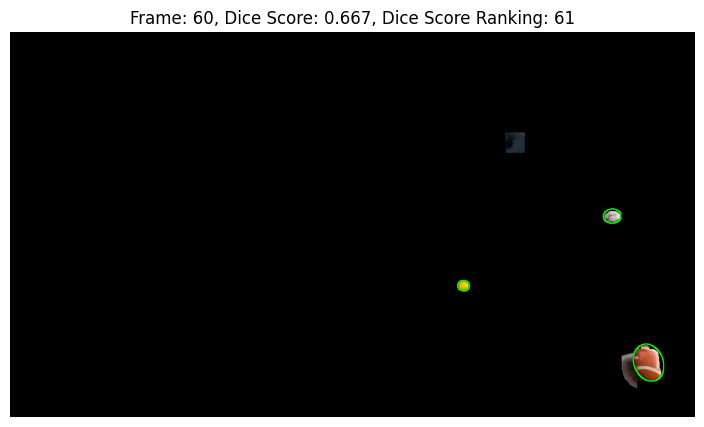

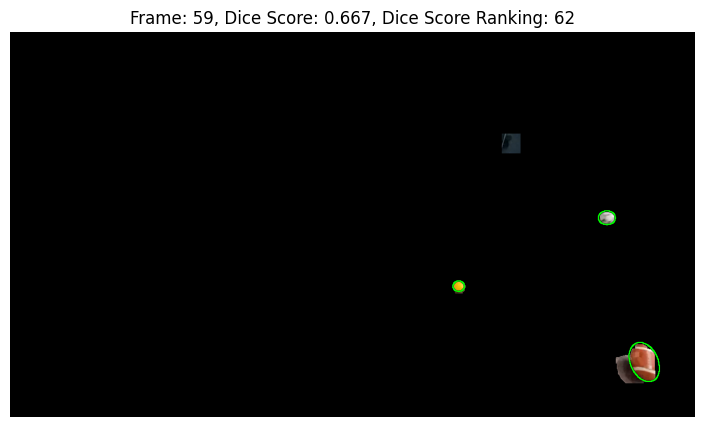

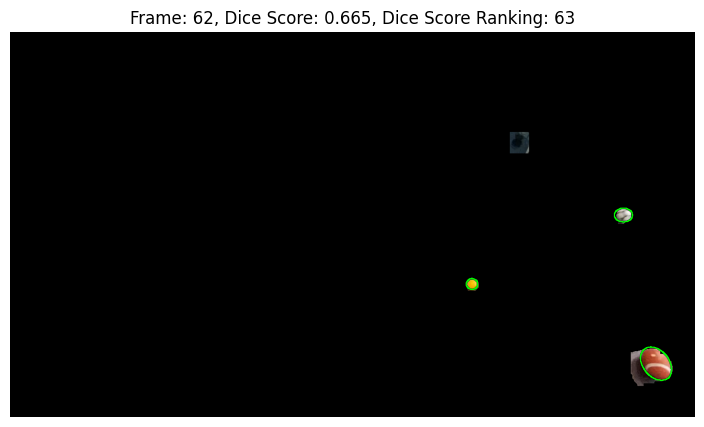

In [11]:
def plot_image_mask_with_gt(idx, rank):
    img = cv2.imread(ball_frame_files[i])
    gt_mask = cv2.imread(ball_frame_gt_files[i])
    gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
    gt_contour = cv2.Canny(gt_mask, 100, 200)
    # gt_mask = gt_mask.astype(np.uint8)
    gt_contour = (1 * (gt_contour > 0)).astype(np.uint8)

    green_img = np.full([*gt_contour.shape, 3], [0,255,0]).astype(np.uint8)

    gt_contour_color = cv2.bitwise_and(green_img, green_img, mask = gt_contour)

    # Threshold V channel at 100 to make alpha channel (A)
    print(gt_contour_color[:,:,1].shape)
    _, A = cv2.threshold(gt_contour_color[:,:,1],100,255,cv2.THRESH_BINARY)
    gt_contour_color = np.dstack((gt_contour_color,A))
    kernel = np.ones((3,3),np.uint8)
    gt_contour_color = cv2.dilate(gt_contour_color, kernel, iterations = 1)

    mask = get_mask(i)
    masked_img = cv2.bitwise_and(img, img, mask = mask)

    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    plt.imshow(gt_contour_color)
    plt.title(f"Frame: {i}, Dice Score: {DSs[i]:.3f}, Dice Score Ranking: {rank}")
    plt.axis('off')

# find index of the 5 highest dice scores
idxs = np.argsort(DSs)[::-1][:5]

for rank, i in enumerate(idxs):
    plt.figure()
    plot_image_mask_with_gt(i, rank+1)
    plt.savefig(f"../report/figures/best_dice_score_{rank+1}.png")


# find index of the 5 lowest dice scores
idxs = np.argsort(DSs)[::-1][-5:]

for rank, i in enumerate(idxs):
    plt.figure()
    rank = len(DSs) - 4 + rank
    plot_image_mask_with_gt(i, rank)
    plt.savefig(f"../report/figures/best_dice_score_{rank}.png")


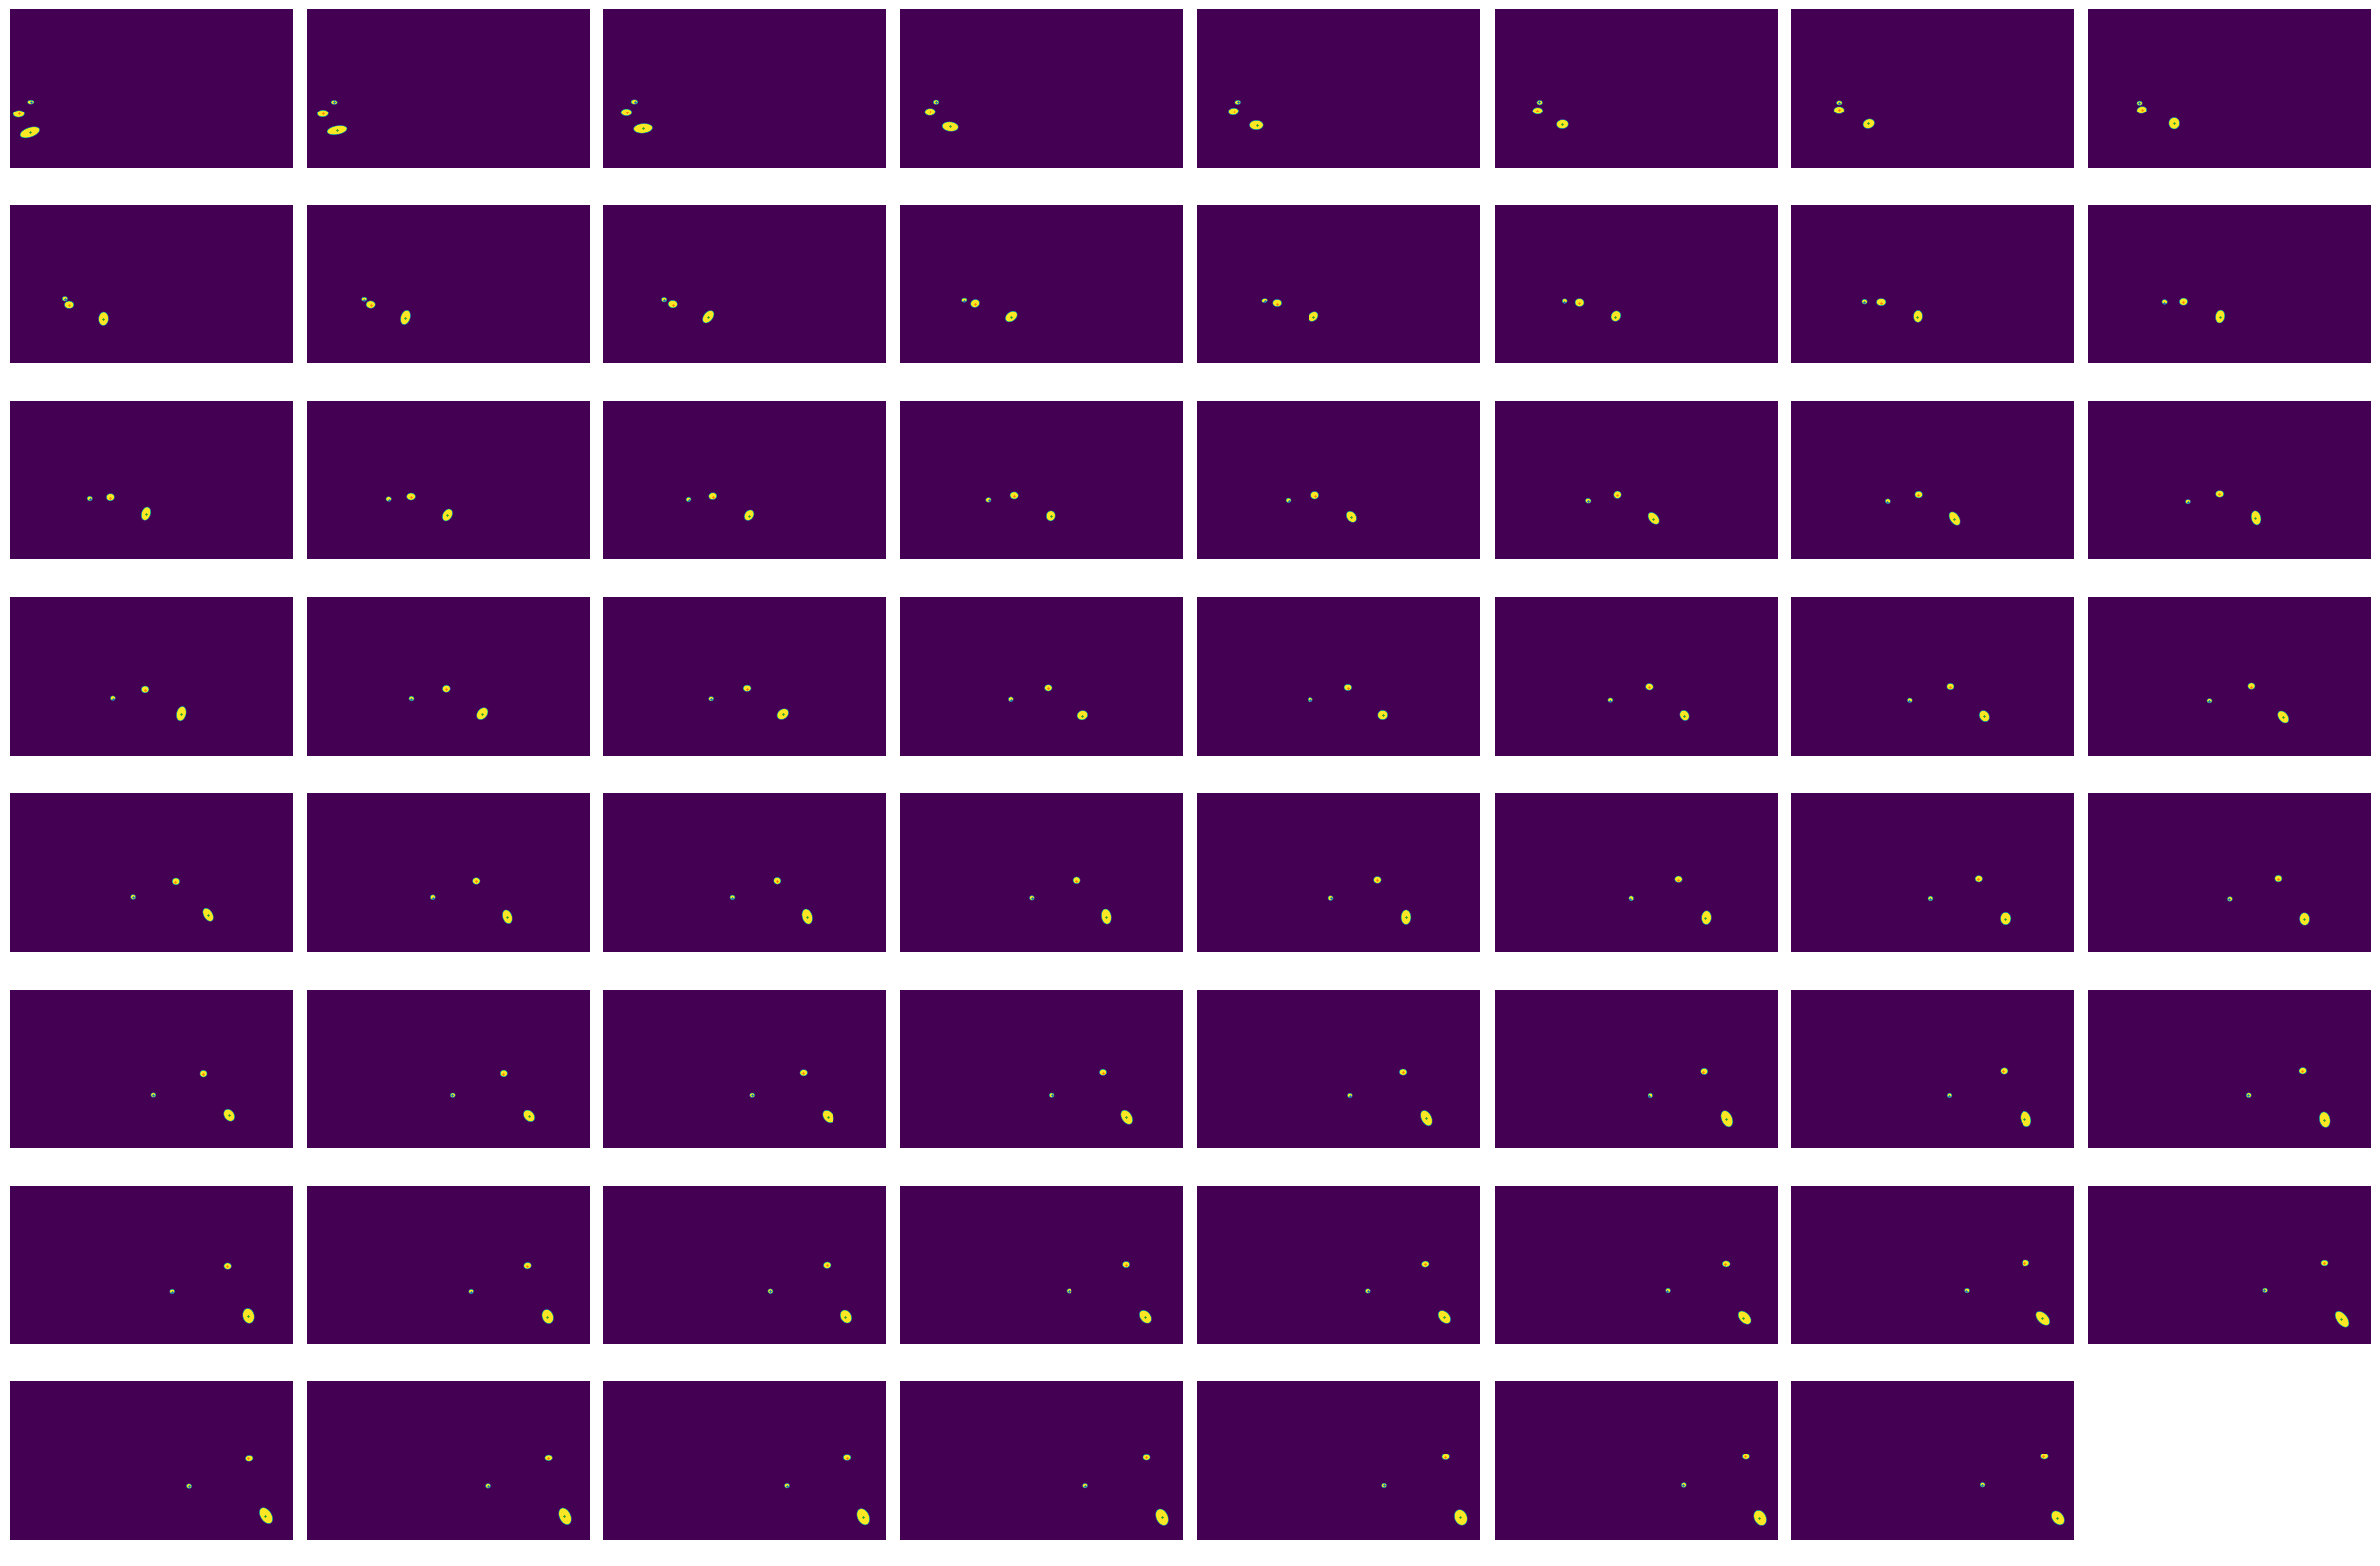

In [12]:
import scipy
import skimage

_, axs = plt.subplots(8, 8, figsize=(24, 16))
axs = axs.flatten()

ball_features = {}
ball_names = ["tennis", "football", "rugby"]

angles = np.array([0, 45, 90, 135])

for ball_name in ball_names:
    ball_features[ball_name] = {
        "solidity": [],
        "circularity": [],
        "non_compactness": [],
        "eccentricity": [],
        "ASM": {c: {a: [] for a in angles} for c in ["r", "g", "b"]},
        "contrast": {c: {a: [] for a in angles} for c in ["r", "g", "b"]},
        "correlation": {c: {a: [] for a in angles} for c in ["r", "g", "b"]},
    }

for i in range(len(ball_frame_files)):
    img = cv2.imread(ball_frame_files[i])
    mask = get_gt_mask(i)

    label, num_features = scipy.ndimage.label(mask)

    label_sizes = [np.sum(label == j + 1) for j in range(num_features)]
    tennis_label = np.argmin(label_sizes) + 1

    label_center_y = [
        scipy.ndimage.center_of_mass(mask, label, j + 1)[0] for j in range(num_features)
    ]
    rugby_label = np.argmax(label_center_y) + 1

    football_label = [j + 1 for j in range(num_features)]
    football_label.remove(tennis_label)
    football_label.remove(rugby_label)
    football_label = football_label[0]

    axs[i].imshow(mask)
    for j in [tennis_label, football_label, rugby_label]:
        y, x = scipy.ndimage.center_of_mass(mask, label, j)
        axs[i].plot([x], [y], "x", markersize=1)

    props = skimage.measure.regionprops(label, img, cache=True)
    solidities = [prop.solidity for prop in props]
    circularity = [(4 * np.pi * prop.area) / prop.perimeter**2 for prop in props]

    non_compactness = []
    for j in range(num_features):
        ball_mask = (label == j + 1).astype(np.uint8)
        mu = skimage.measure.moments_central(ball_mask)
        nc = 2 * np.pi * (mu[0, 2] + mu[2, 0]) / (mu[0, 0] ** 2)
        non_compactness.append(nc)

    eccentricity = [prop.eccentricity for prop in props]

    for ball_name, ball_label in zip(
        ball_names, [tennis_label, football_label, rugby_label]
    ):
        ball_features[ball_name]["solidity"].append(solidities[ball_label - 1])
        ball_features[ball_name]["circularity"].append(circularity[ball_label - 1])
        ball_features[ball_name]["non_compactness"].append(
            non_compactness[ball_label - 1]
        )
        ball_features[ball_name]["eccentricity"].append(eccentricity[ball_label - 1])

        ball_mask = (label == ball_label).astype(np.uint8)
        patch = cv2.bitwise_and(img, img, mask=ball_mask)

        for channel, channel_name in zip(range(3), ["b", "g", "r"]):
            g = skimage.feature.graycomatrix(
                patch[:, :, channel],
                distances=[1],
                angles=angles / 180 * np.pi,
                levels=256,
                normed=True,
                symmetric=True,
            )
            contrast = skimage.feature.graycoprops(g, "contrast")
            correlation = skimage.feature.graycoprops(g, "correlation")
            ASM = skimage.feature.graycoprops(g, "ASM")

            for i, a in enumerate(angles):
                ball_features[ball_name]["contrast"][channel_name][a].append(
                    contrast[0, i]
                )
                ball_features[ball_name]["correlation"][channel_name][a].append(
                    correlation[0, i]
                )
                ball_features[ball_name]["ASM"][channel_name][a].append(ASM[0, i])

for ax in axs:
    ax.axis("off")
plt.tight_layout()

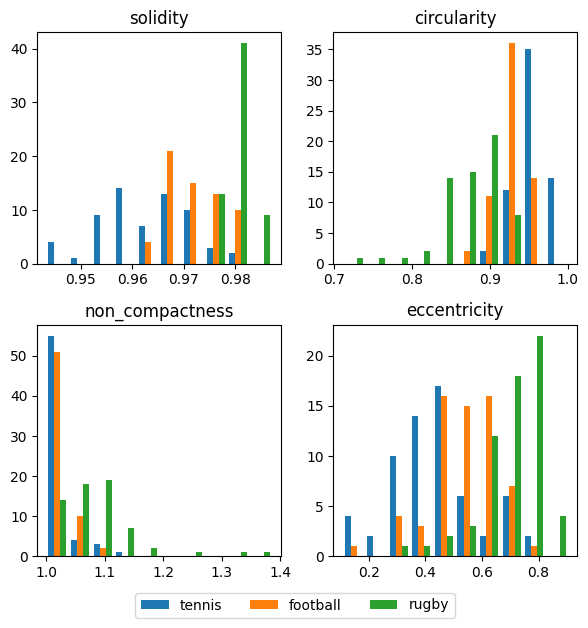

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

for j, feature in enumerate(
    ["solidity", "circularity", "non_compactness", "eccentricity"]
):
    axes[j].hist(
        [ball_features[ball][feature] for ball in ball_names], label=ball_names
    )
    axes[j].set_title(f"{feature}")
    # axes[j].legend()

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(
    labels, loc="lower center", labelspacing=0.0, ncol=3, bbox_to_anchor=(0.5, -0.05)
)
plt.tight_layout()
plt.savefig("../report/figures/shape_features_hist.png")

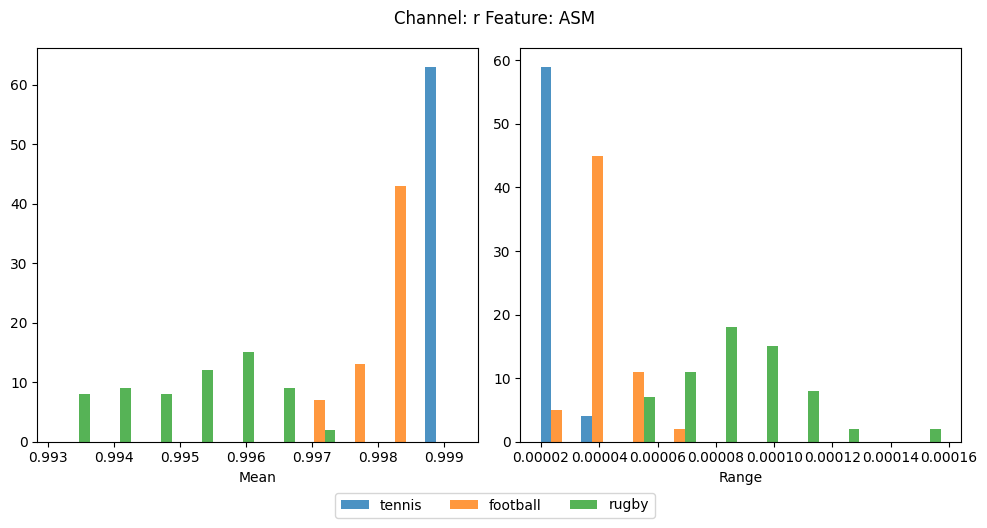

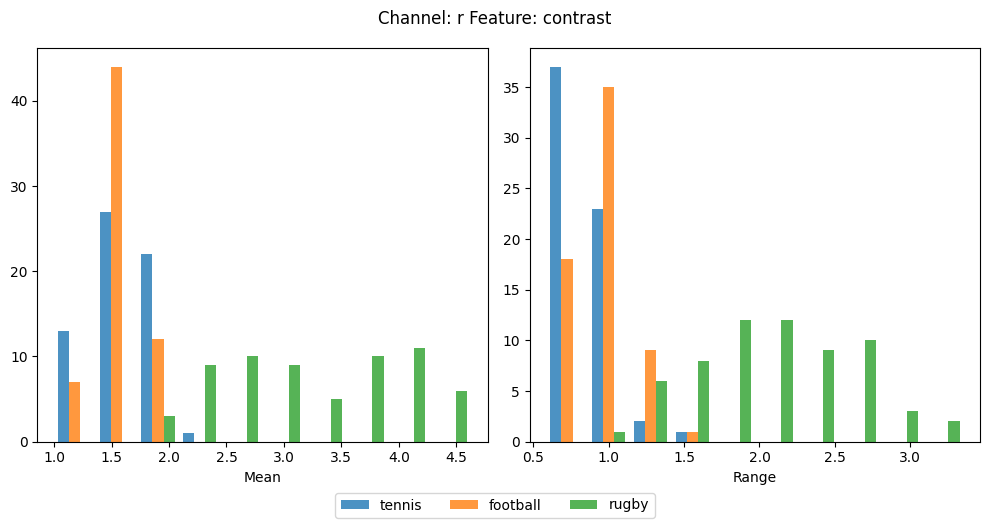

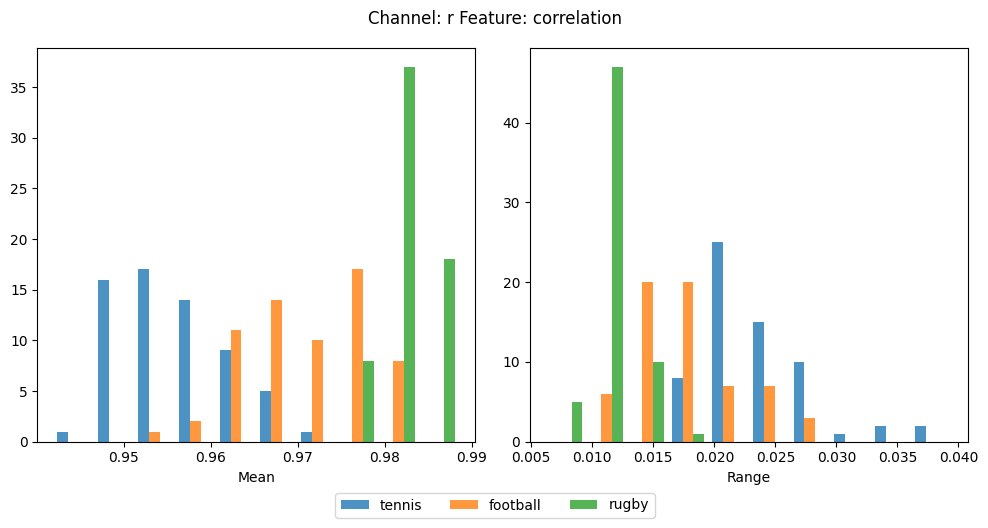

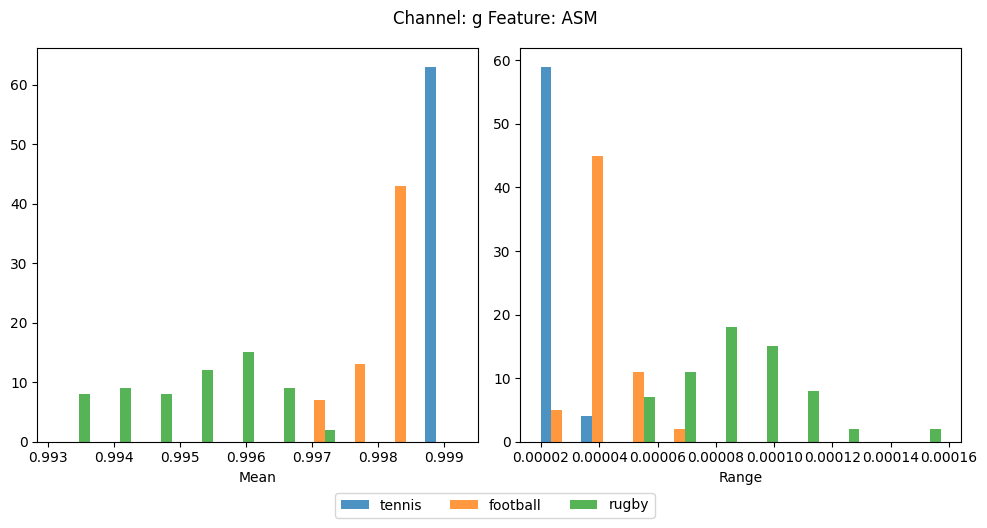

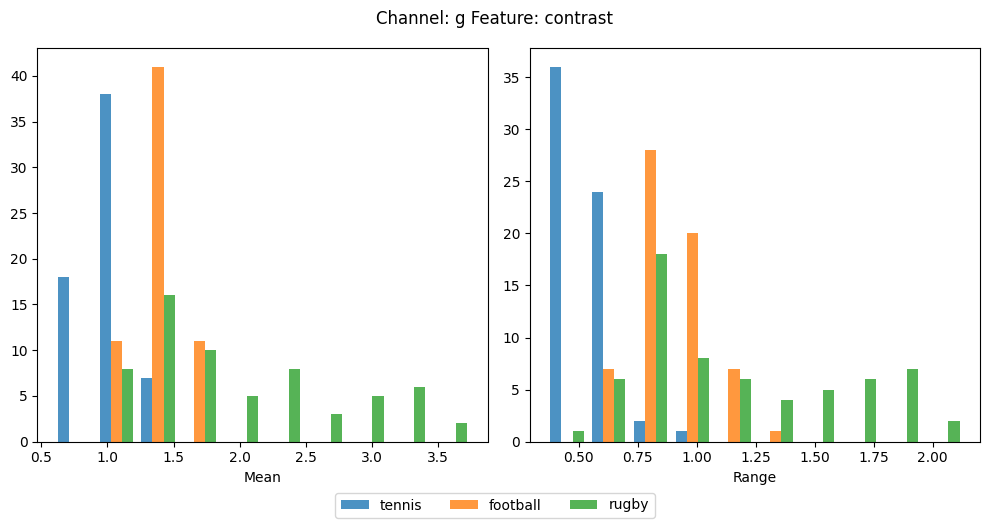

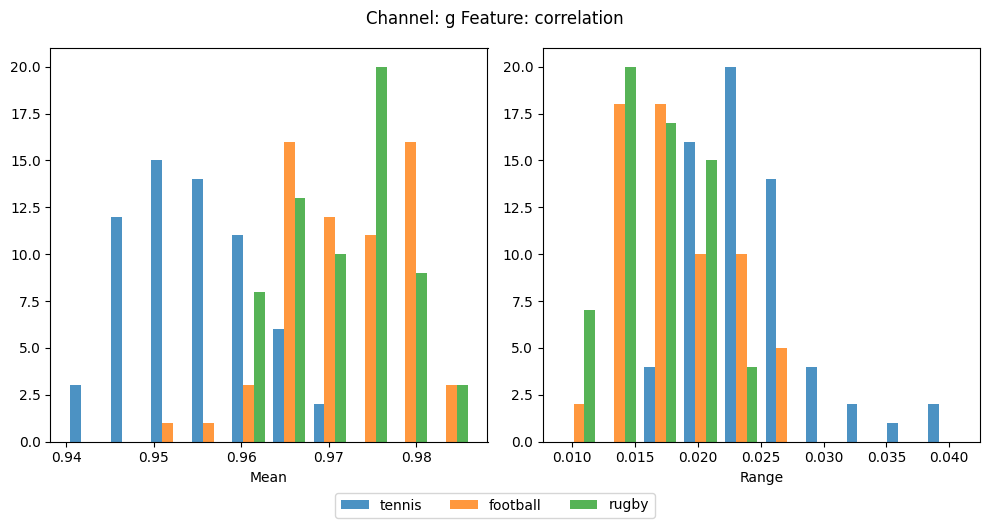

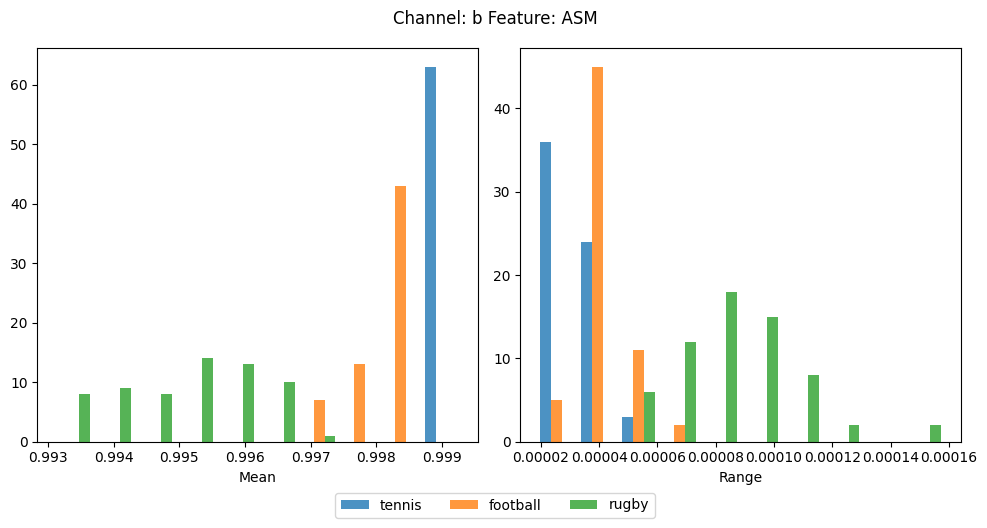

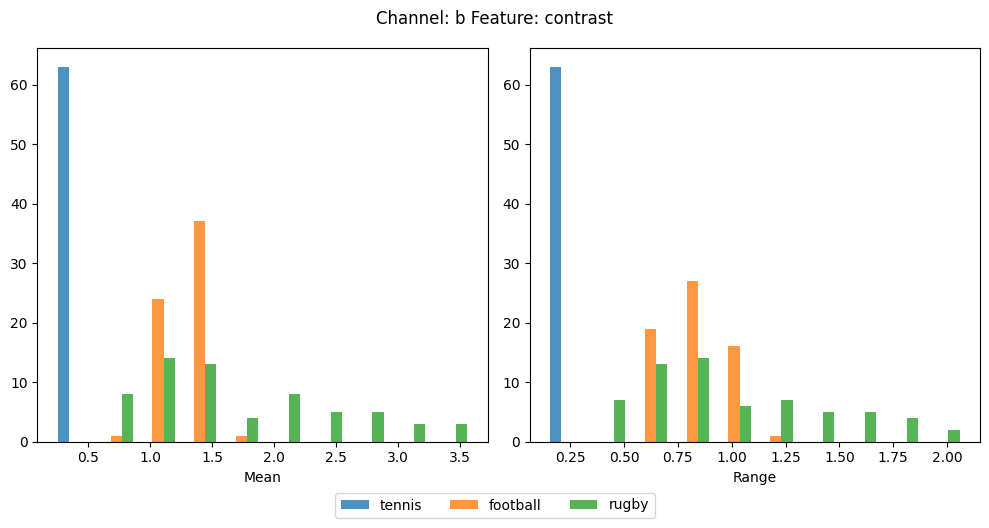

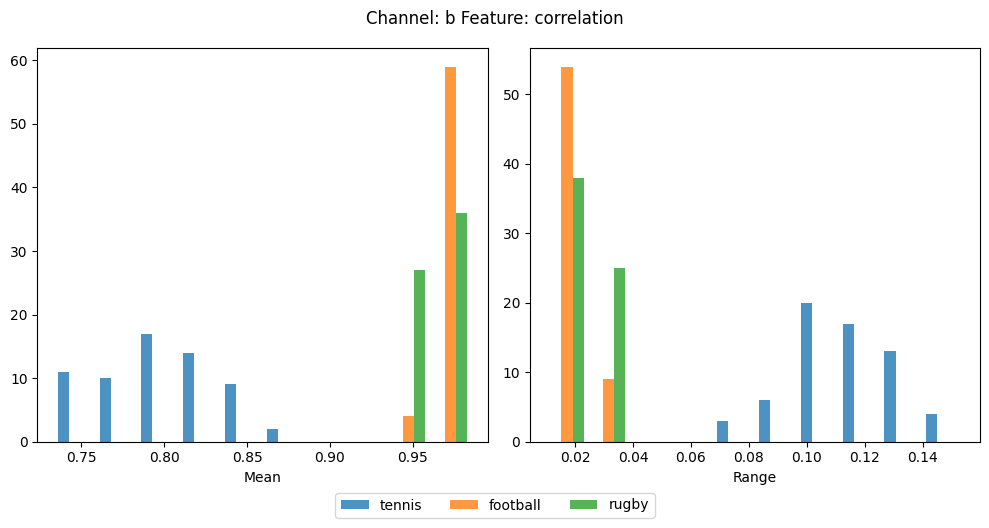

In [18]:
import seaborn as sns

colors = sns.color_palette()

texture_features = {
    f: {c: [] for c in ["r", "g", "b"]} for f in ["ASM", "contrast", "correlation"]
}

for c in ["r", "g", "b"]:
    for feature in ["ASM", "contrast", "correlation"]:
        texture_features_data = []
        for ball_name in ball_names:
            features_means = []
            features_ranges = []
            for i in range(len(ball_frame_files)):
                feature_values = [
                    ball_features[ball_name][feature][c][a][i] for a in angles
                ]
                feature_mean = np.mean(feature_values)
                feature_range = np.max(feature_values) - np.min(feature_values)
                features_means.append(feature_mean)
                features_ranges.append(feature_range)
            texture_features_data.append((features_means, features_ranges))

        fig, axes = plt.subplots(1, 2)
        data = [x[0] for x in texture_features_data]
        axes[0].hist(
            data,
            label=ball_names,
            # color=[colors[3], colors[2], colors[0]],
            alpha=0.8
        )
        axes[0].set_xlabel("Mean")


        axes[1].hist(
            [x[1] for x in texture_features_data],
            label=ball_names,
            # color=[colors[3], colors[2], colors[0]],
            alpha=0.8
        )
        axes[1].set_xlabel("Range")

        fig.suptitle(f"Channel: {c} Feature: {feature}")
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.figlegend(
            labels, loc="lower center", labelspacing=0.0, ncol=3, bbox_to_anchor=(0.5, -0.05)
        )
        plt.tight_layout()
        plt.savefig(f"../report/figures/{c}_{feature}.png", bbox_inches='tight')

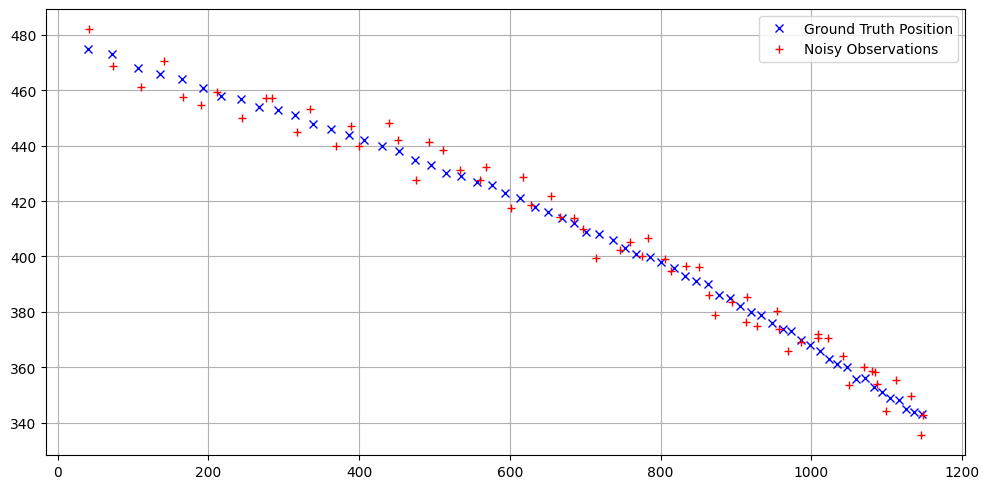

In [15]:
def load_var(name):
    val = []
    with open(name+".csv", "r") as fd:
        val = [float(x) for x in fd.read().strip().split(",")]
    return np.array(val)

u = load_var("na")
v = load_var("nb")
x = load_var("x")
y = load_var("y")

plt.plot(x, y, "bx", label="Ground Truth Position")
plt.plot(u, v, "r+", label="Noisy Observations")
# plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()


RMS Error:  5.876551627837961


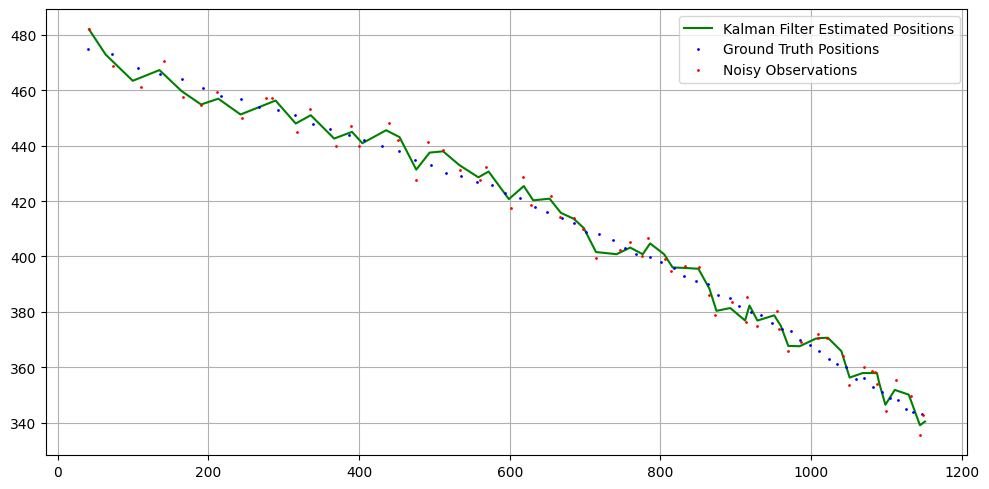

In [27]:
def kalmanPredict(x, P, F, Q):
    xp = F @ x
    # predict state
    Pp = F @ P @ F.transpose() + Q
    # predict state covariance
    return xp, Pp


def kalmanUpdate(x, P, H, R, z):
    # print(H.shape, P.shape, R.shape)
    S = H @ P @ H.transpose() + R
    # innovation covariance
    K = P @ H.transpose() @ np.linalg.inv(S)
    # Kalman gain
    zp = H @ x
    # predicted observation

    gate = (z - zp).transpose() @ np.linalg.inv(S) @ (z - zp)

    # if gate > 9.21:
    if gate > 10000000:
        plt.plot(z[0], z[1], "ro", label="excluded observation")
        print("Observation outside validation gate")
        xe = x
        Pe = P
    else:
        xe = x + K @ (z - zp)
        # estimated state
        Pe = P - K @ S @ K.transpose()
        # estimated covariance

    return xe, Pe


def kalmanTracking(z, measurement_noise=0.25, motion_noise=0.36):
    dt = 0.5
    # time interval
    N = len(z[0])
    # number of samples

    # fmt: off
    F = np.array([
        [1,dt,0,0],
        [0,1,0,0],
        [0,0,1,dt],
        [0,0,0,1]]) # CV motion model
    Q = np.array([
        [0.16,0,0,0],
        [0,0.36,0,0],
        [0,0,0.16,0],
        [0,0,0,0.36]]) # motion noise
    H = np.array([
        [1,0,0,0],
        [0,0,1,0]]) # Cartesian observation model
    R = np.array([
        [measurement_noise, 0],
        [0, measurement_noise]]) # observation noise
    # fmt: on

    x = np.array([u[0], 0, v[0], 0]).transpose()
    # initial state
    P = Q
    # initial state covariance
    s = np.zeros([4, N])
    for i in range(N):
        xp, Pp = kalmanPredict(x, P, F, Q)
        x, P = kalmanUpdate(xp, Pp, H, R, z[:, i])
        s[:, i] = x
        # save current state

    px = s[0, :]  # NOTE: s(2, :) and s(4, :), not considered here,
    py = s[2, :]

    return px, py


# print(len(u), len(v))
px, py = kalmanTracking(np.array([u, v]))

plt.plot(px, py, "g-", label="Kalman Filter Estimated Positions")
plt.plot(x, y, "b.", label="Ground Truth Positions", ms=2)
plt.plot(u, v, "r.", label="Noisy Observations", ms=2)
# plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()
plt.savefig('../report/figures/kalman_filter_default_values.png')


e = (px - x) ** 2 + (py - y) ** 2
rms = np.sqrt(np.sum(e) / len(e))
print("RMS Error: ", rms)

24.710277258854237


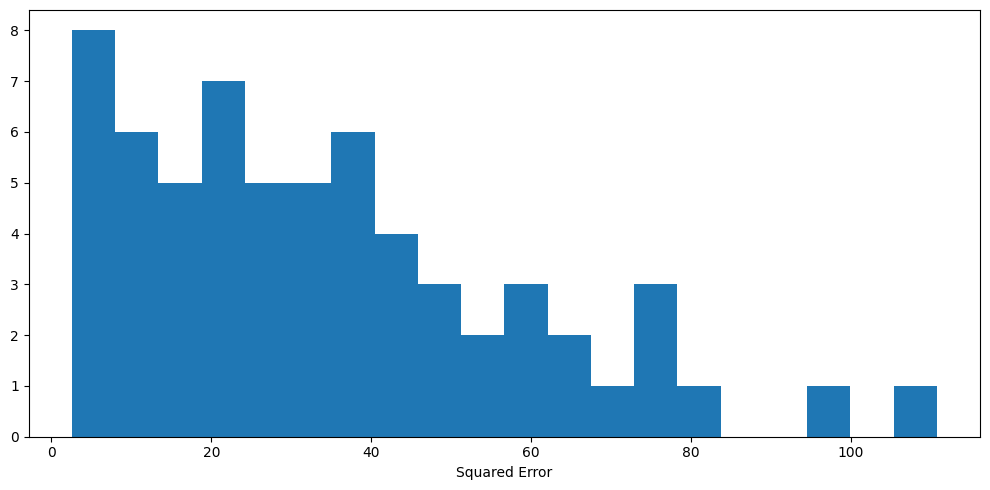

In [25]:
plt.hist(e, bins=20)
plt.xlabel("Squared Error")
plt.tight_layout()
plt.savefig('../report/figures/kalman_filter_error_hist.png')

print(np.std(e))

RMS Error:  11.776536502602156


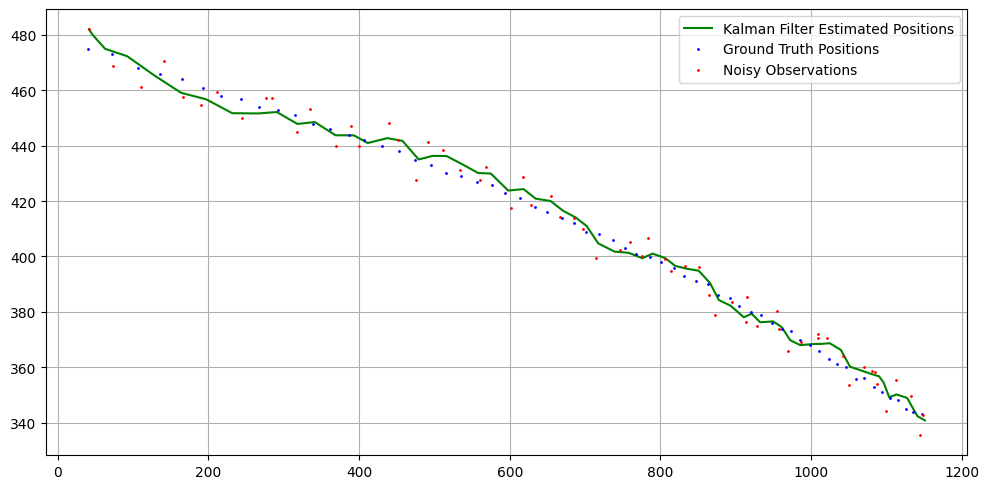

In [31]:
# print(len(u), len(v))
px, py = kalmanTracking(np.array([u, v]), measurement_noise=5)

plt.plot(px, py, "g-", label="Kalman Filter Estimated Positions")
plt.plot(x, y, "b.", label="Ground Truth Positions", ms=2)
plt.plot(u, v, "r.", label="Noisy Observations", ms=2)
# plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()
plt.savefig('../report/figures/kalman_filter_larger_obs_noise.png')

e = (px - x) ** 2 + (py - y) ** 2
rms = np.sqrt(np.sum(e) / len(e))
print("RMS Error: ", rms)

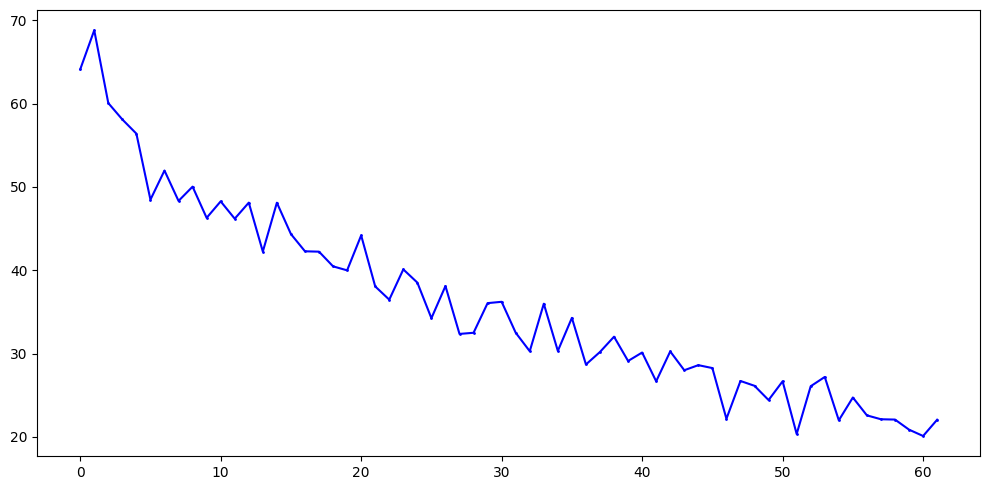

In [35]:
ground_truth = np.array([x, y])
velocities = np.diff(ground_truth, axis=1) / 0.5

plt.plot(np.sqrt(velocities[0]**2 + velocities[1]**2), "b.-", label="Ground Truth Velocities", ms=2)
plt.tight_layout()
plt.savefig('../report/figures/ground_truth_velocity.png')
